# 模組 5.4: 案例實戰 - Insurance 資料集

## 學習目標
- 在一個真實的資料集上，綜合應用本模組學習到的特徵縮放與變數轉換技術。
- 根據特徵的分佈（偏態、常態）和是否存在異常值，為其選擇最恰當的預處理策略。
- 實作一個包含多種縮放和轉換方法的完整預處理流程。
- 比較不同預處理策略對特徵分佈的影響。

## 導論：整合與應用

我們已經分別學習了特徵縮放（StandardScaler, MinMaxScaler, RobustScaler）和變數轉換（Log, Box-Cox, Yeo-Johnson）。現在，我們將把這些技術應用到 `insurance` 資料集上，為其中的數值特徵制定一個完整的預處理方案。

目標是將原始的數值特徵轉換為更適合機器學習模型（特別是線性模型）使用的形式。

In [8]:
# 導入必要的函式庫
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer

import matplotlib.pyplot as plt
# 設定視覺化風格
# 'seaborn-v0_8-whitegrid' 提供了帶有白色網格的 seaborn 預設風格，更易於讀取
plt.style.use('seaborn-v0_8-whitegrid')
# 設置中文字體，以防圖表標題或標籤出現亂碼
# 請確保您的環境中已安裝 'Microsoft JhengHei' 或其他中文字型
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 
plt.rcParams['axes.unicode_minus'] = False  # 解決負號顯示問題
print("Matplotlib and Seaborn styles configured.")

# 忽略不必要的警告訊息
import warnings
warnings.filterwarnings('ignore')

Matplotlib and Seaborn styles configured.


## 1. 載入資料與初步分析

我們先載入資料，並對數值特徵的分佈進行一次快速的視覺化檢視。

成功載入 Insurance 資料集!


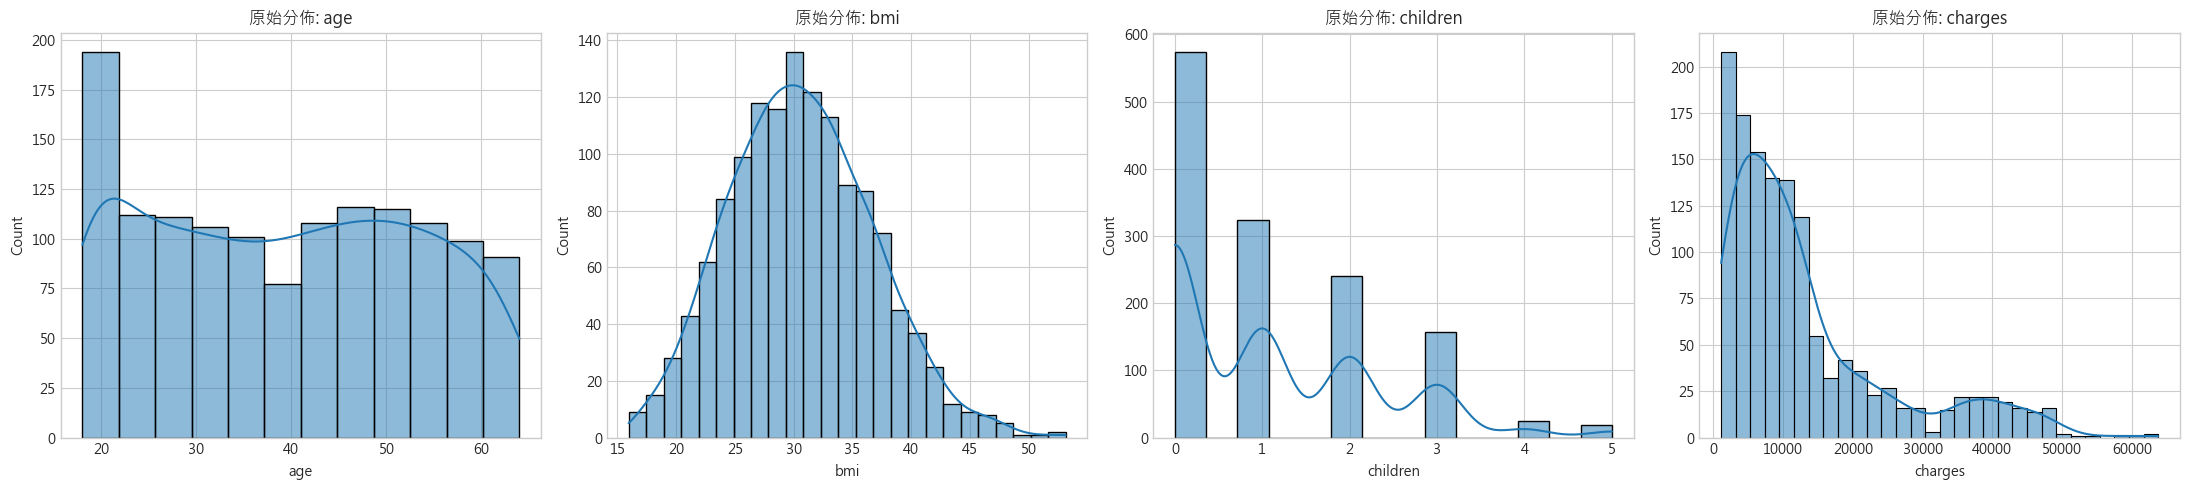

In [9]:
# 載入資料
path = r'..\..\..\..\datasets\raw\insurance\insurance.csv'
try:
    df = pd.read_csv(path)
    # 我們只關心數值特徵
    df_numeric = df.select_dtypes(include=np.number)
    print("成功載入 Insurance 資料集!")
except FileNotFoundError:
    print(f"在 '{path}' 找不到 insurance.csv。")
    df_numeric = pd.DataFrame()

# 繪製原始數值特徵的分佈
fig, axes = plt.subplots(1, 4, figsize=(22, 5))
for i, col in enumerate(df_numeric.columns):
    sns.histplot(df_numeric[col], kde=True, ax=axes[i])
    axes[i].set_title(f'原始分佈: {col}')
plt.tight_layout()
plt.show()



**初步分析與策略制定**:

1.  **`age`**: 分佈較為均勻，沒有明顯的偏態或極端異常值。可以使用 `StandardScaler`。
2.  **`bmi`**: 看起來非常接近常態分佈（高斯分佈），是 `StandardScaler` 的理想應用對象。
3.  **`children`**: 這是一個離散的計數變數，值不大。可以直接使用，或者如果模型需要也可以進行縮放。我們暫時保持原樣，或使用 `StandardScaler`。
4.  **`charges`**: 明顯的 **高度右偏** 分佈。這是 **冪轉換 (Power Transformation)** 的絕佳候選。在轉換之後，再進行縮放。

## 2. 實施預處理流程

我們將建立一個新的 DataFrame `df_processed` 來存放處理後的結果。

In [10]:
# 建立工作副本
df_processed = df_numeric.copy()

# --- 步驟 1: 處理 charges (冪轉換 + 縮放) ---

# 1a. 應用對數轉換 (Log-Transform) 來處理偏態
# 使用 log1p 以應對可能存在的 0 值
df_processed['charges'] = np.log1p(df_processed['charges'])

# 1b. 對轉換後的 charges 進行縮放
# 由於轉換後分佈更對稱，StandardScaler 是個好選擇
scaler_charges = StandardScaler()
df_processed['charges'] = scaler_charges.fit_transform(df_processed[['charges']])


# --- 步驟 2: 處理 age, bmi, children (縮放) ---

# 2a. 對 age 和 bmi 使用 StandardScaler
scaler_std = StandardScaler()
cols_to_scale_std = ['age', 'bmi']
df_processed[cols_to_scale_std] = scaler_std.fit_transform(df_processed[cols_to_scale_std])

# 2b. 對 children，我們也可以用 StandardScaler
# RobustScaler 也是一個選項，如果我們認為計數本身可能包含異常行為
scaler_robust = RobustScaler()
df_processed['children'] = scaler_robust.fit_transform(df_processed[['children']])


print("所有數值特徵處理完成。")




所有數值特徵處理完成。


## 3. 視覺化比較處理前後的結果

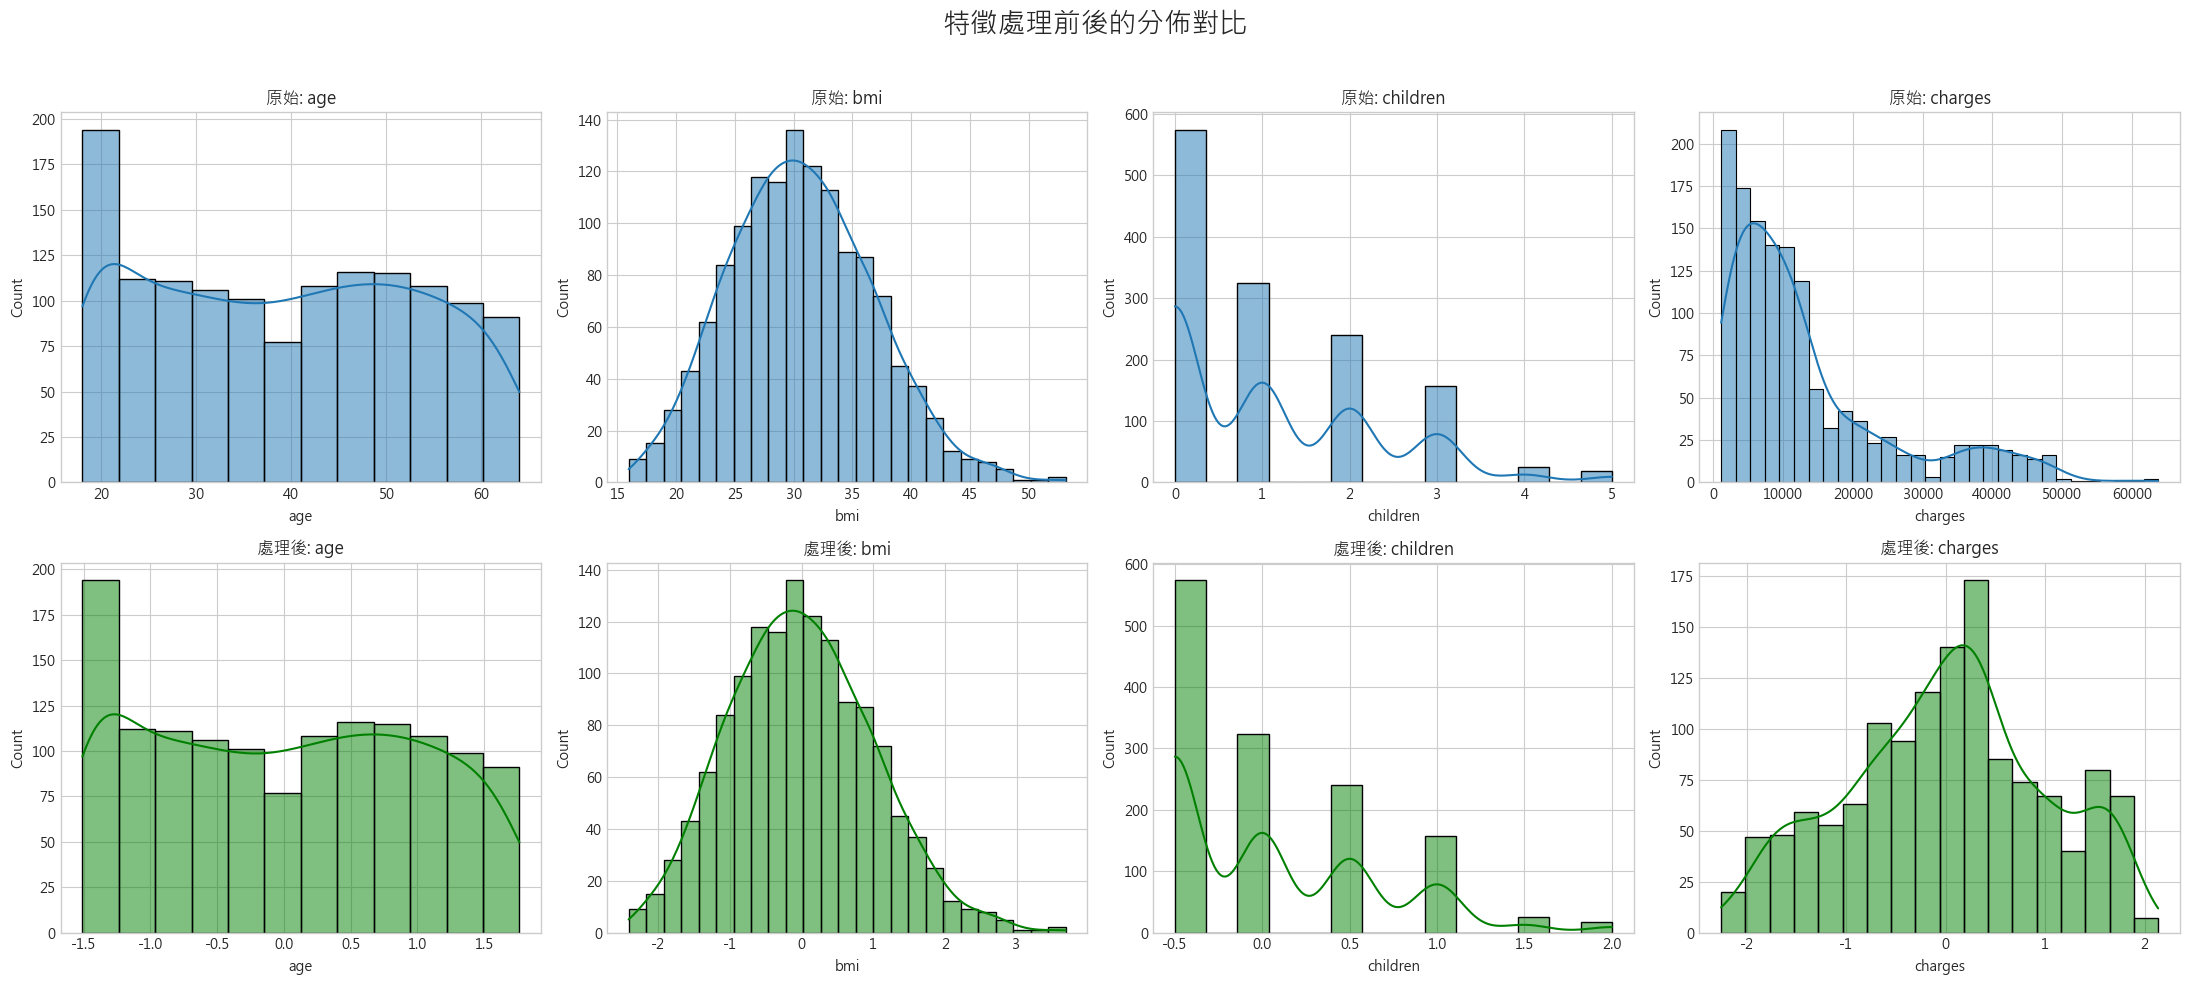

In [11]:
fig, axes = plt.subplots(2, 4, figsize=(22, 10))
fig.suptitle('特徵處理前後的分佈對比', fontsize=20)

# 繪製原始分佈
for i, col in enumerate(df_numeric.columns):
    sns.histplot(df_numeric[col], kde=True, ax=axes[0, i])
    axes[0, i].set_title(f'原始: {col}')

# 繪製處理後的分佈
for i, col in enumerate(df_processed.columns):
    sns.histplot(df_processed[col], kde=True, ax=axes[1, i], color='green')
    axes[1, i].set_title(f'處理後: {col}')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()



**結果解讀**:

- **charges (第4列)**: 對比最為明顯。原始的高度右偏分佈，在經過 **對數轉換 + 標準化** 之後，變成了一個漂亮的、以 0 為中心的類常態分佈。
- **age, bmi (第1, 2列)**: 它們的 **形狀沒有改變**，但其 **尺度** (x軸) 已經被轉換為以 0 為中心，標準差為 1 的分佈。
- **children (第3列)**: 經過 `RobustScaler` 縮放後，其尺度也發生了變化，但保留了其離散的特性。

現在，所有特徵都在一個可比較的尺度上，並且最強的偏態特徵 `charges` 也被成功地「馴服」了。這個 `df_processed` DataFrame 遠比原始數據更適合直接用於訓練線性模型或基於距離的模型。

## 總結

這個案例實戰展示了一個系統化的數值特徵預處理流程：

1.  **檢視分佈**: 首先透過視覺化理解每個特徵的分佈形狀。
2.  **制定策略**:
    - 對於 **偏態嚴重** 的特徵，**先轉換，再縮放** (e.g., `Log Transform` -> `StandardScaler`)。
    - 對於 **接近常態** 或沒有明顯偏態的特徵，直接進行 **縮放** (e.g., `StandardScaler`)。
    - 對於可能含有異常值的特徵，考慮使用 `RobustScaler`。
3.  **應用與驗證**: 實施策略，並再次視覺化以確認處理效果。

這個流程將特徵縮放和變數轉換的知識結合起來，形成了一套強大的、可用於大多數場景的數值預處理方案。